# Construct GRN using CellOracle
**Authorship:** Adam Klie (last updated: 08/15/2023)<br>
***
**Description:** This notebook takes in an h5ad file with raw counts in it and will preprocess it for CellOracle.
***

# Set-up

In [1]:
# Global imports
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import celloracle as co

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(

0.14.0


In [2]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [ ]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results"

# Inputs
in_date = "10Aug23"
in_dir = os.path.join(results_dir, dataset_name, in_date)
print(in_dir)

# Outputs
out_analysis = "grn_model_construction"
out_date = "10Aug23"
out_dir = os.path.join(results_dir, dataset_name, out_date, out_analysis)
make_dirs(out_dir)

In [ ]:
# Make and log a yaml file with the parameters
data_params = {
    "dataset_name": dataset_name,
    "results_dir": results_dir,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_analysis": out_analysis,
    "out_date": out_date,
    "out_dir": out_dir,
}
version_params = {
    "Python": sys.version[:5],
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "scanpy": sc.__version__,
    "seaborn": sns.__version__,
    "celloracle": co.__version__,
}
params = {"data": data_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "grn_model_construction_params.yaml")):
    with open(os.path.join(out_dir, "grn_model_construction_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load the preprocessed scRNA-seq data

In [5]:
adata_path = os.path.join(results_dir, dataset_name, now, "scRNAseq_data_preparation", "scRNA_processed.h5ad")
adata_path

'/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_grns/celloracle/results/igvf_sc-islet_10X-Multiome/10Aug23/scRNAseq_data_preparation/scRNA_processed.h5ad'

In [6]:
adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 83289 × 2999
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'nCount_mpeak', 'nFeature_mpeak', 'batch', 'condition', 'time_point', 'sample', 'atac_raw_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_pct.mt', 'TSS.enrichment', 'TSS.percentile', 'mpeak.weight', 'wsnn_res.0.3', 'cell.type.1', 'cell.type.2', 'predicted.cell.type', 'predicted.cell.type.score', 'n_counts_all', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'log1p', 'neighbors', 'pca', 'predicted.cell.type_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_wnn'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [8]:
# Random downsampling into 30K cells if the anndata object include more than 30 K cells.
n_cells_downsample = 30000
if adata.shape[0] > n_cells_downsample:
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

<AxesSubplot: >

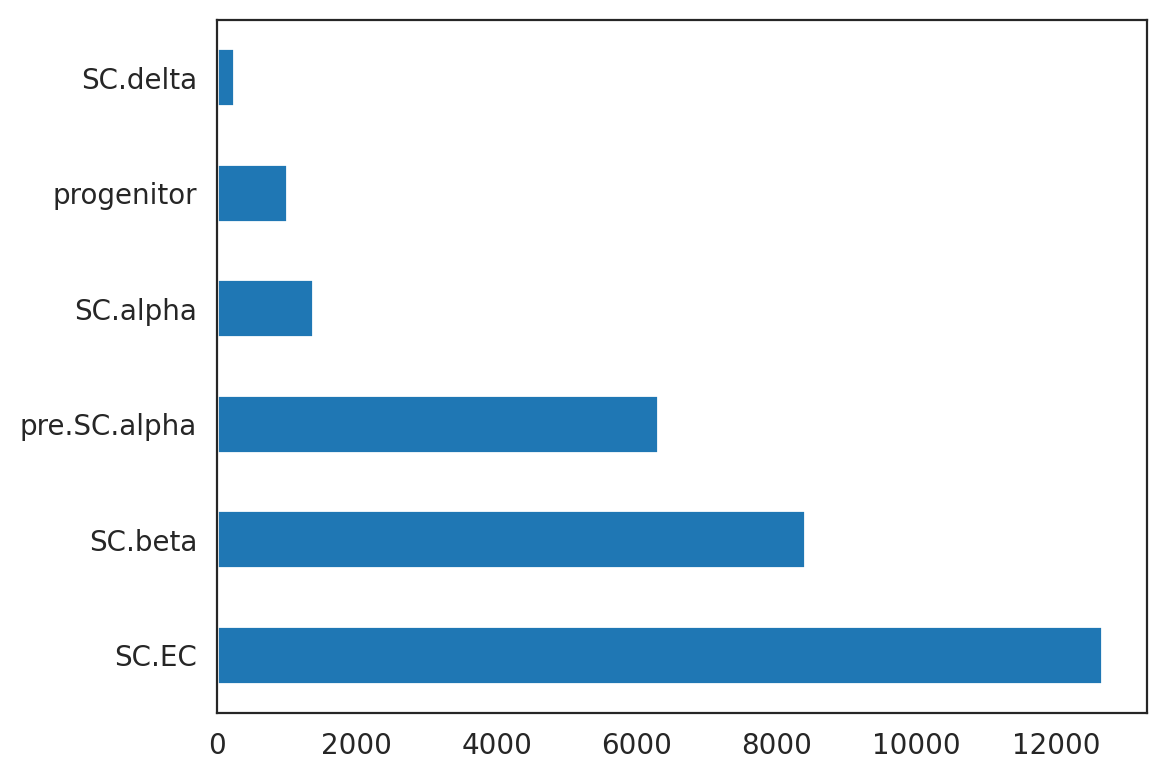

In [9]:
adata.obs["predicted.cell.type"].value_counts().plot.barh()

In [14]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :30000
Gene number is :2999


# Base GRN

In [13]:
base_GRN = pd.read_parquet(os.path.join(results_dir, dataset_name, now, "base_grn_construction", "base_GRN_dataframe.parquet"))

In [15]:
# Check data
base_GRN.head()

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009436_100010350,DNMBP,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr10_100081010_100082022,CPN1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,chr10_100185574_100186492,ERLIN1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr10_100229112_100229961,CHUK,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,chr10_100267214_100268148,CWF19L1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Oracle time

In [16]:
# Instantiate Oracle object
oracle = co.Oracle()

In [17]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'nCount_mpeak', 'nFeature_mpeak', 'batch', 'condition', 'time_point', 'sample', 'atac_raw_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_pct.mt', 'TSS.enrichment', 'TSS.percentile', 'mpeak.weight', 'wsnn_res.0.3', 'cell.type.1', 'cell.type.2', 'predicted.cell.type', 'predicted.cell.type.score', 'n_counts_all', 'n_counts']
Dimensional reduction:  ['X_pca', 'X_umap', 'X_umap_wnn']


In [18]:
adata.layers

Layers with keys: raw_counts

In [19]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_counts"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="predicted.cell.type",
    embedding_name="X_umap_wnn"
)

In [20]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [21]:
# Perform PCA
oracle.perform_PCA()

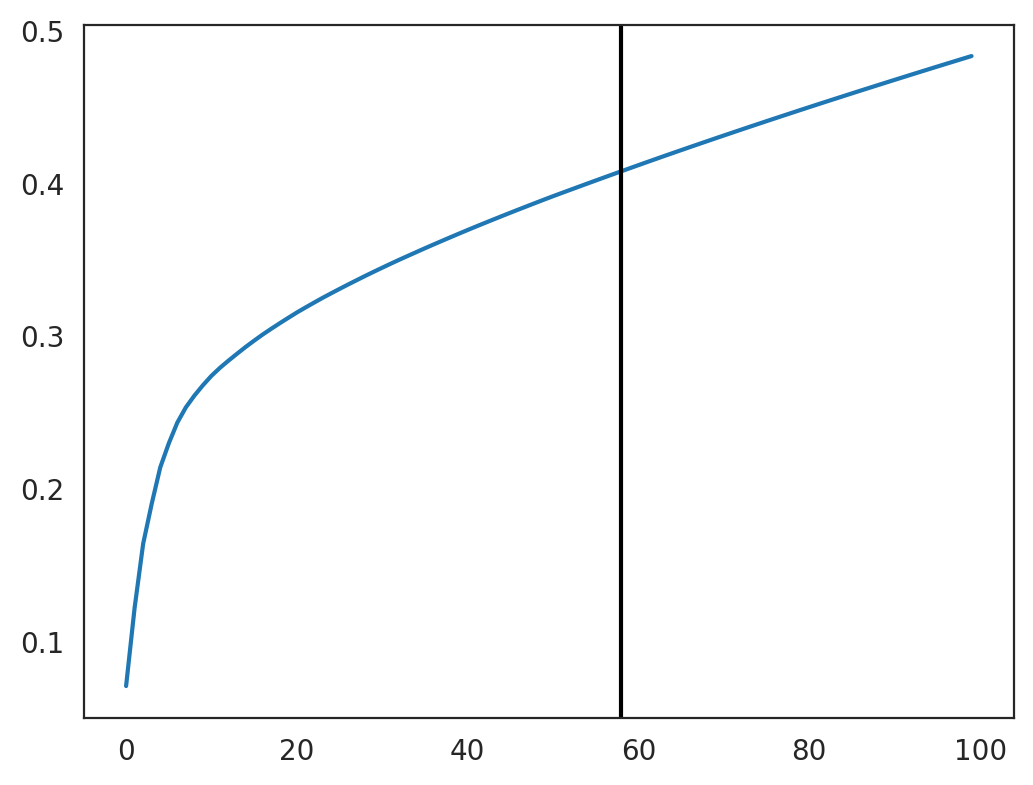

58


In [22]:
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [23]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :30000


In [24]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :750


In [26]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [27]:
oracle.to_hdf5(os.path.join(results_dir, dataset_name, now, "grn_model_construction", "grn_obj.celloracle.oracle"))

In [28]:
links = oracle.get_links(
    cluster_name_for_GRN_unit="predicted.cell.type", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/6 [00:00<?, ?it/s]

Inferring GRN for SC.EC...


  0%|          | 0/1903 [00:00<?, ?it/s]

Inferring GRN for SC.alpha...


  0%|          | 0/1903 [00:00<?, ?it/s]

Inferring GRN for SC.beta...


  0%|          | 0/1903 [00:00<?, ?it/s]

Inferring GRN for SC.delta...


  0%|          | 0/1903 [00:00<?, ?it/s]

Inferring GRN for pre.SC.alpha...


  0%|          | 0/1903 [00:00<?, ?it/s]

Inferring GRN for progenitor...


  0%|          | 0/1903 [00:00<?, ?it/s]

In [29]:
links.links_dict.keys()

dict_keys(['SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta', 'pre.SC.alpha', 'progenitor'])

In [32]:
links.to_hdf5(file_path=os.path.join(results_dir, dataset_name, now, "grn_model_construction", "grn.celloracle.links"))

In [33]:
oracle.to_hdf5(os.path.join(results_dir, dataset_name, now, "grn_model_construction", "grn.celloracle.oracle"))

In [34]:
links.palette

,palette
SC.EC,#1F77B4
SC.alpha,#FF7F0E
SC.beta,#2CA02C
SC.delta,#D62728
pre.SC.alpha,#9467BD
progenitor,#8C564B


In [35]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [36]:
plt.rcParams["figure.figsize"] = [9, 4.5]

SC.EC


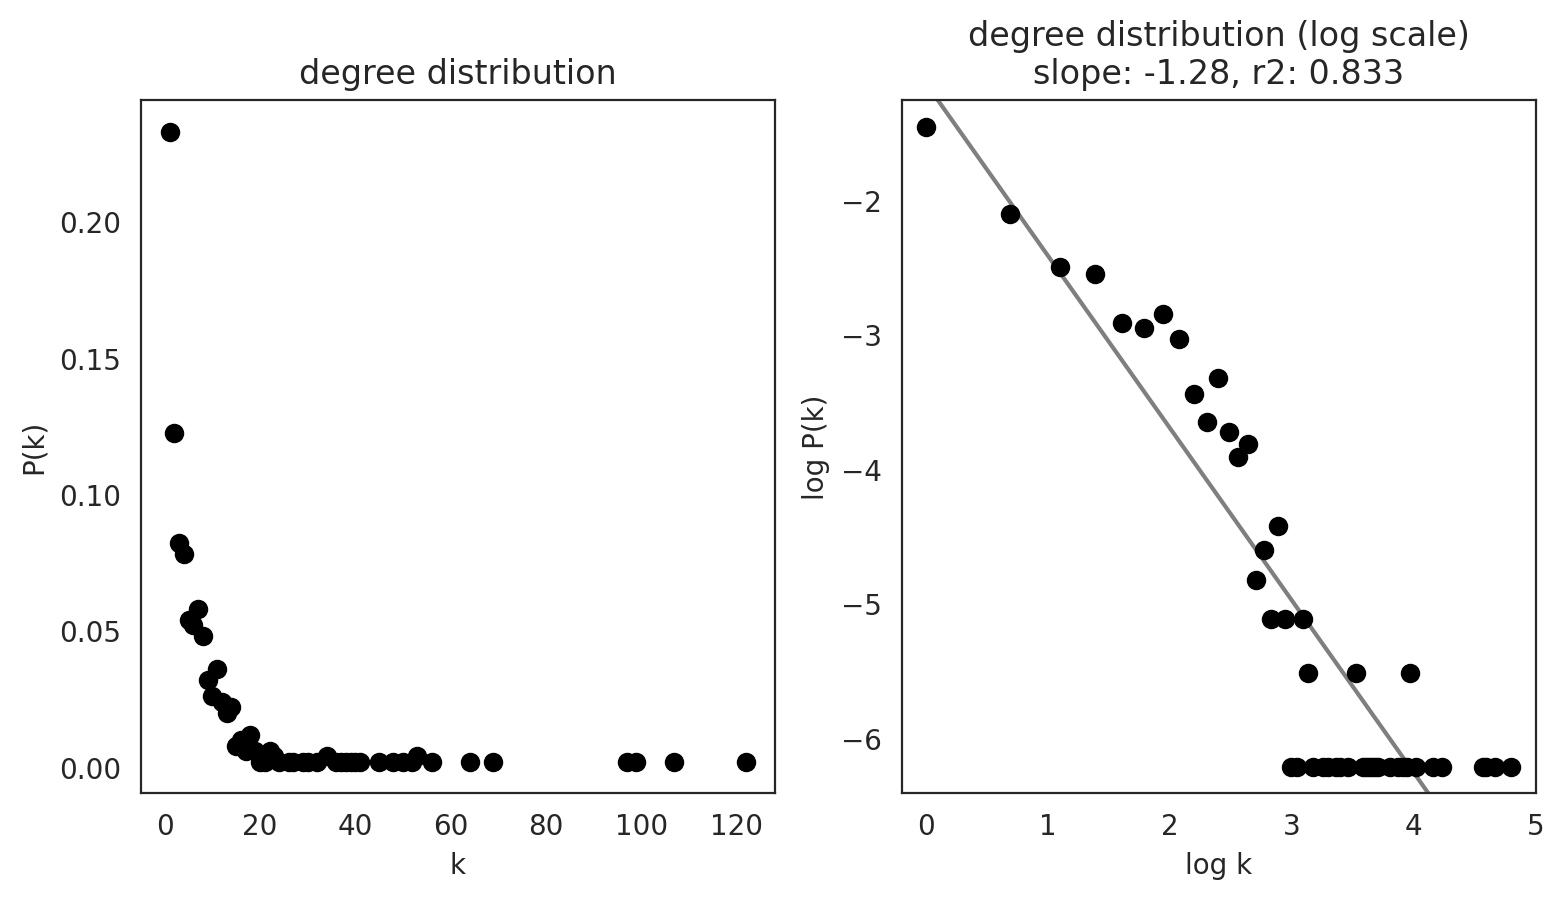

SC.alpha


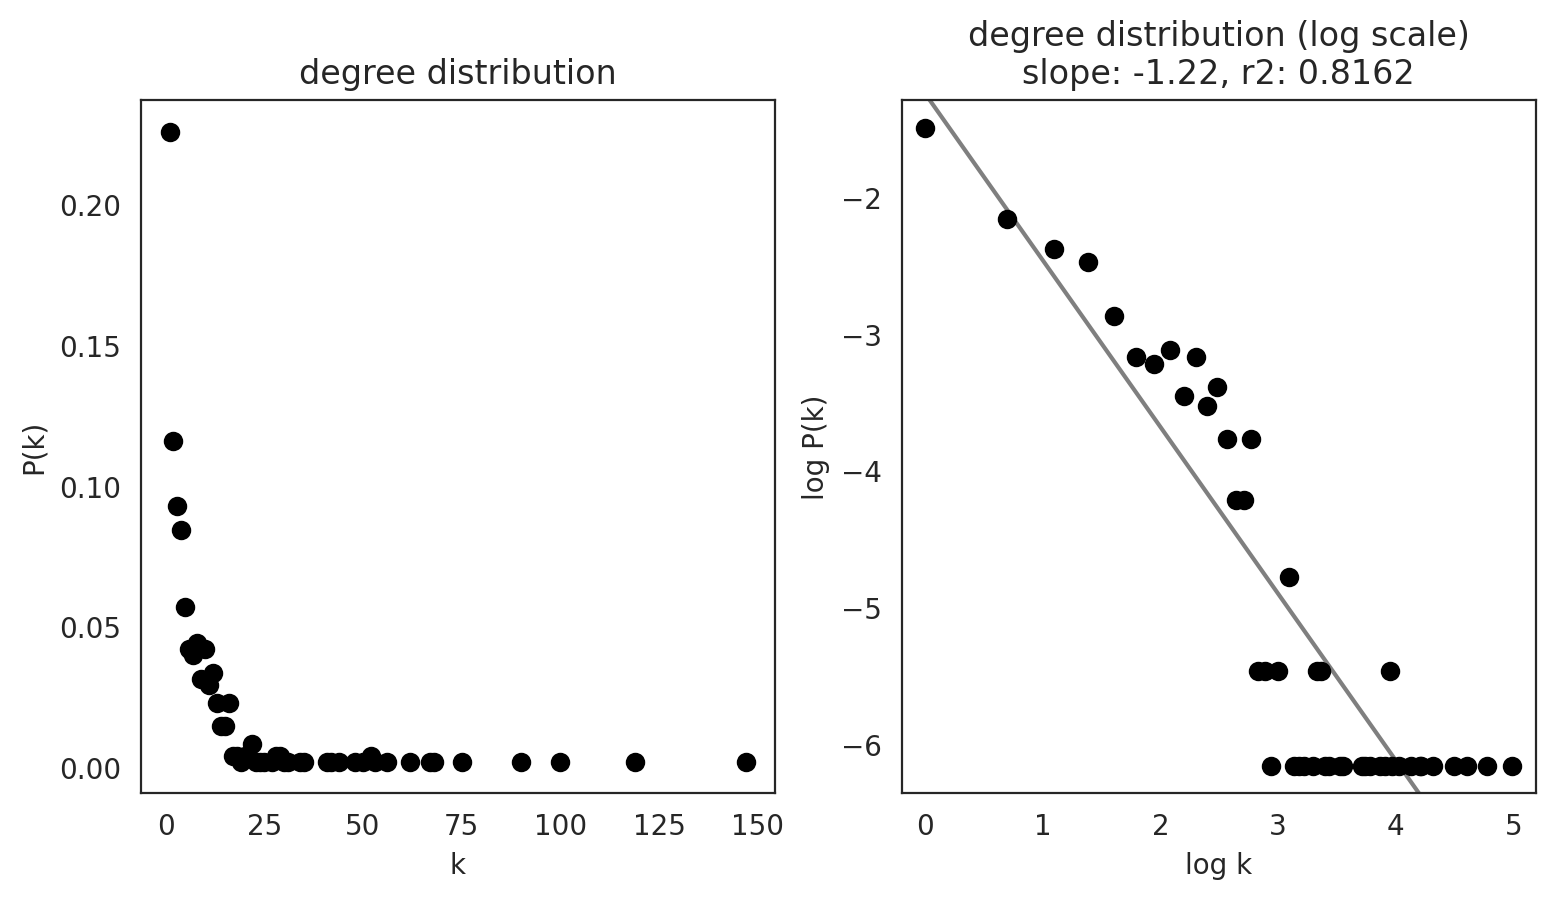

SC.beta


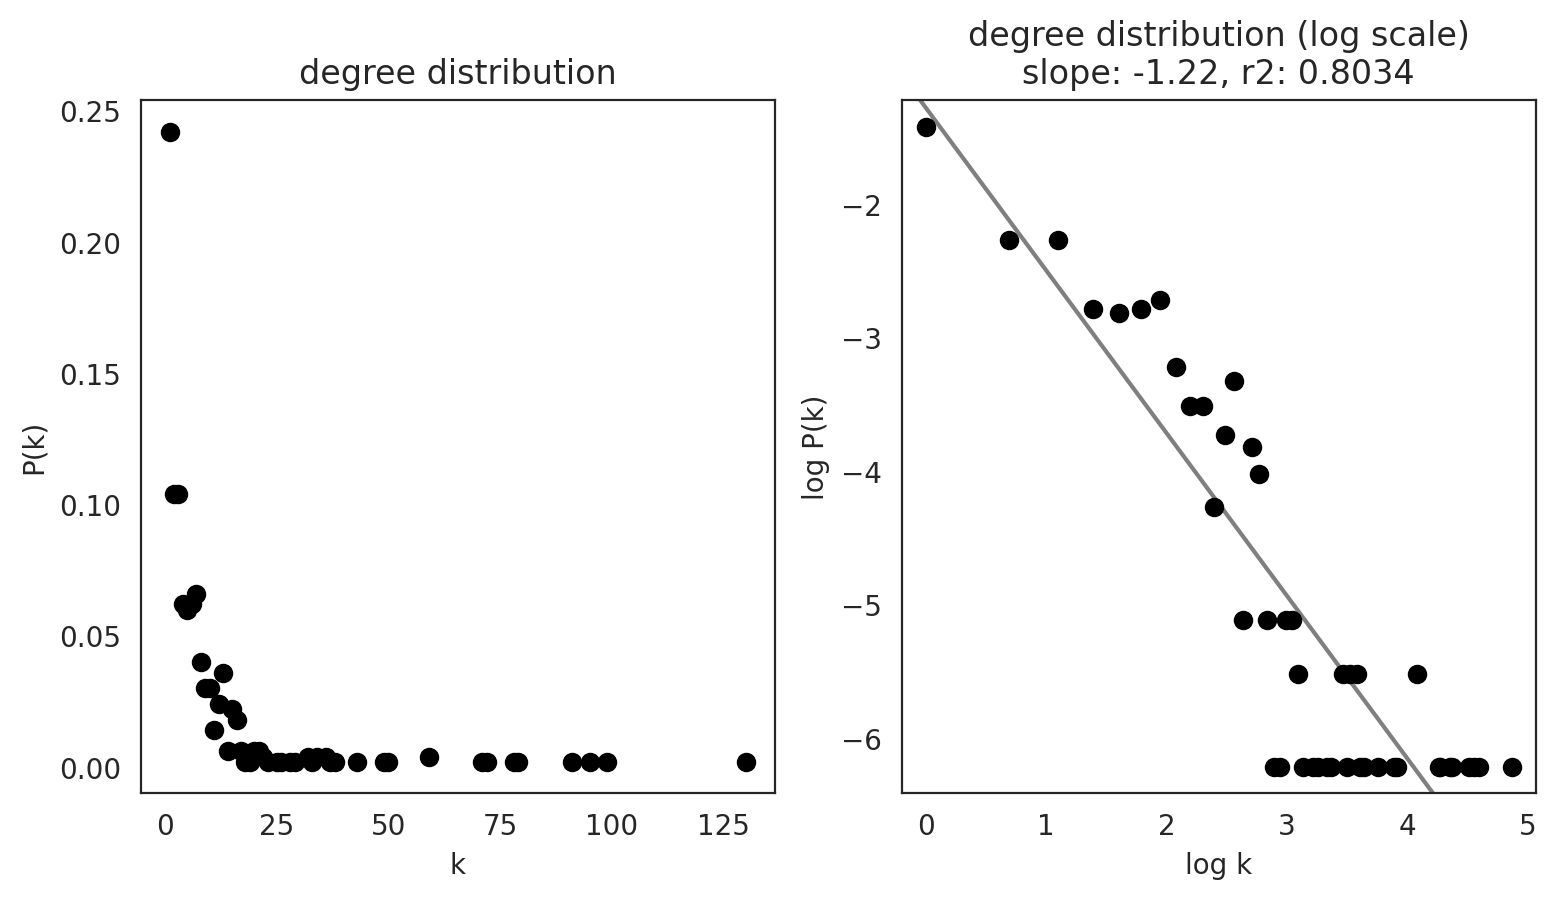

SC.delta


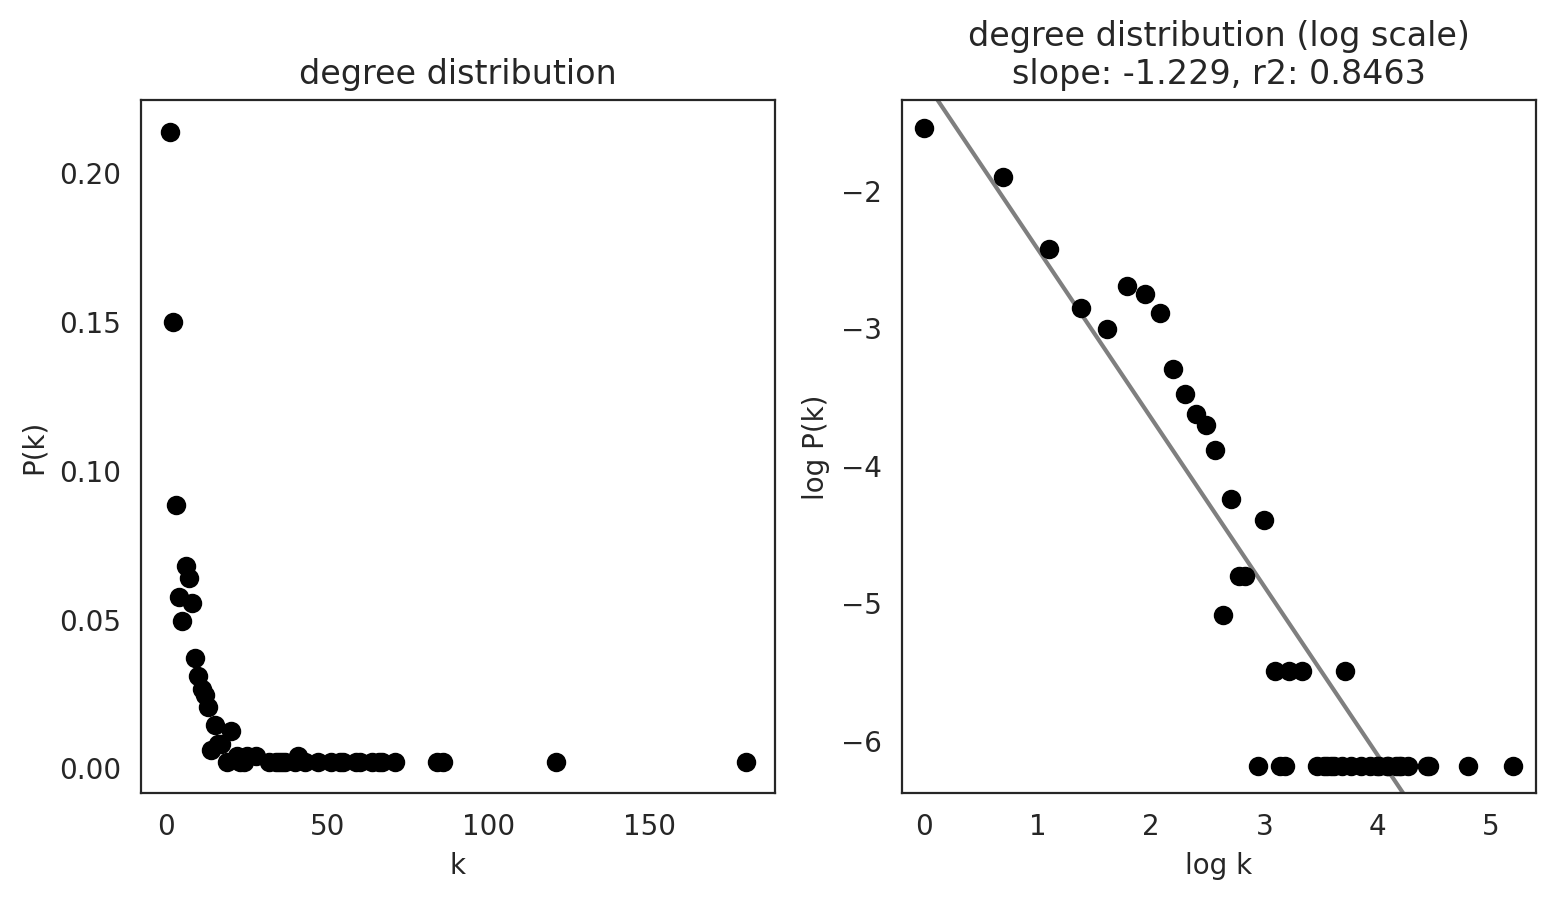

pre.SC.alpha


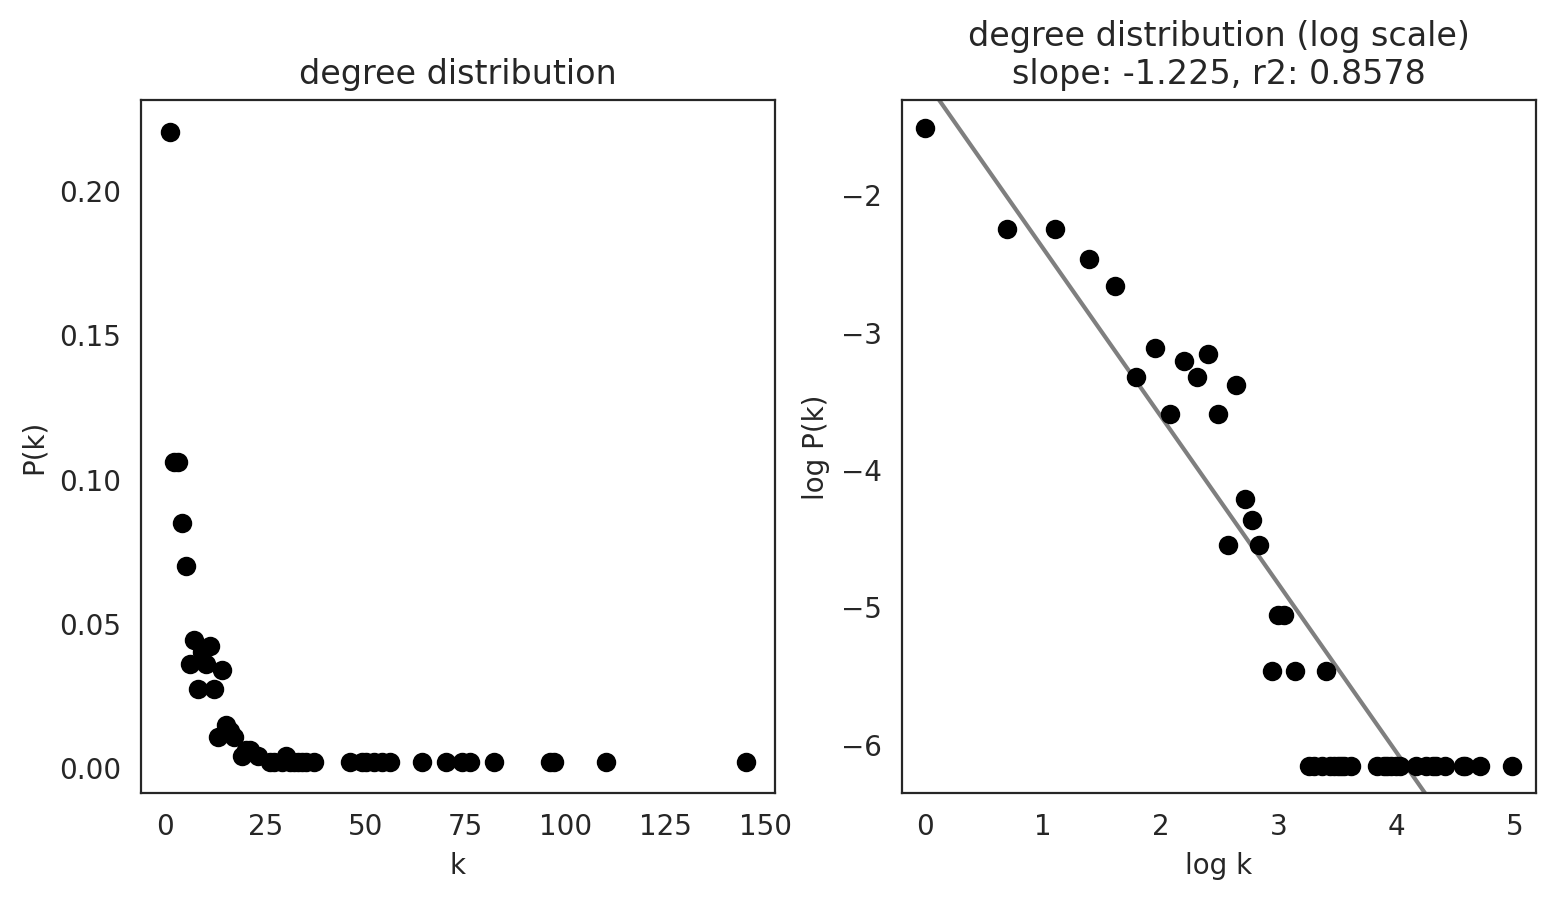

progenitor


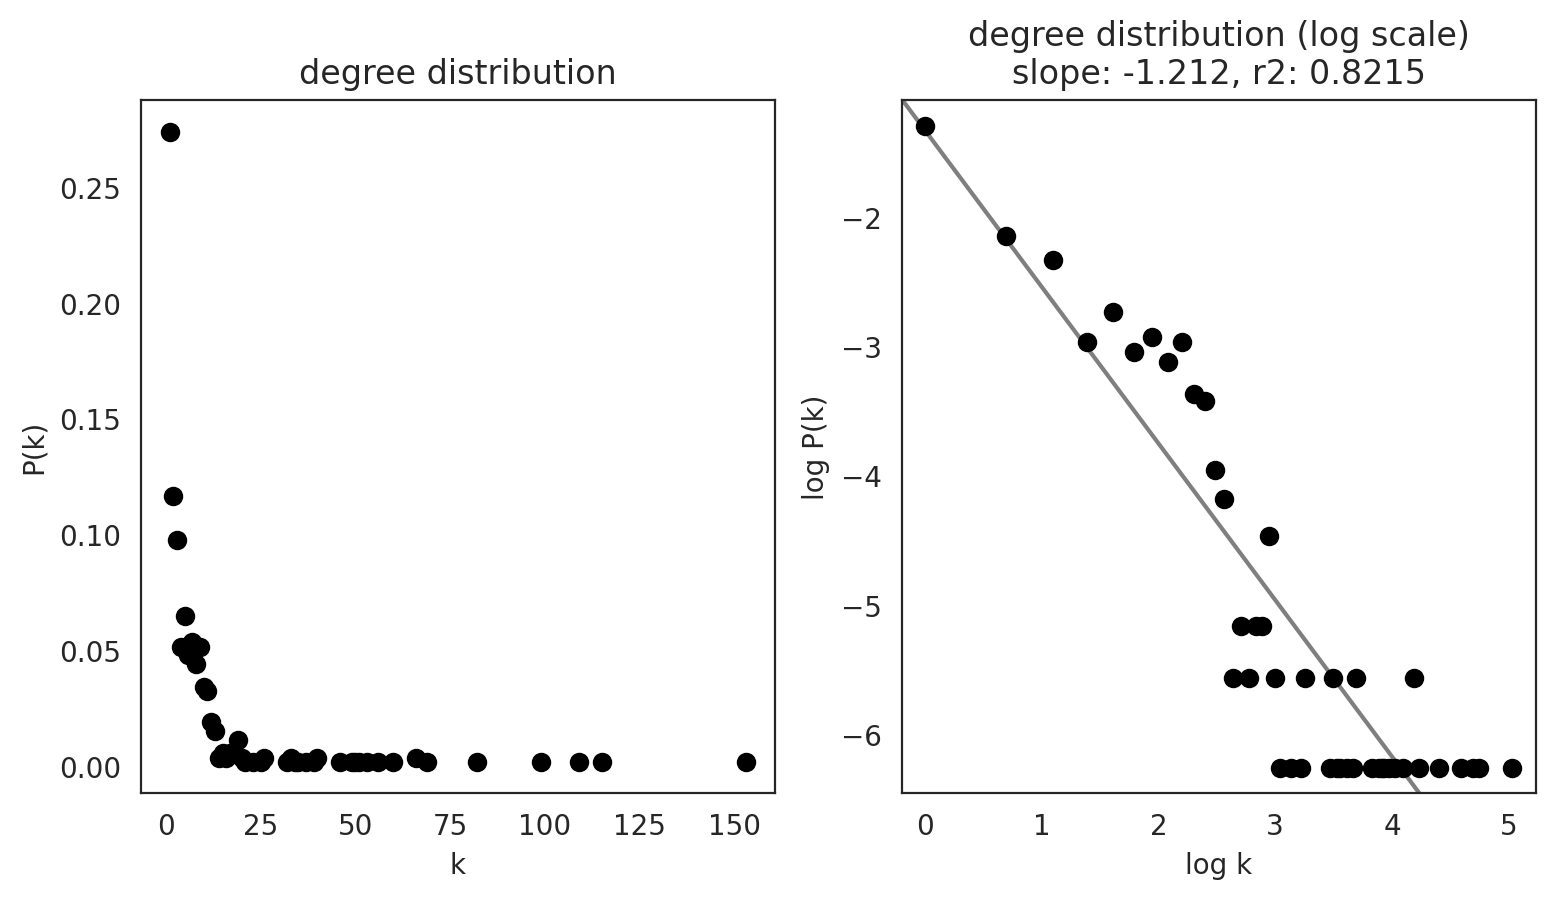

In [37]:
links.plot_degree_distributions(plot_model=True)

In [38]:
# Calculate network scores.
links.get_network_score()

In [39]:
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
NFIA,23,0.046278,0,0.000000,23,0.046278,0.0,0.420167,SC.EC
DACH2,8,0.016097,8,0.016097,0,0.000000,0.0,0.328988,SC.EC
ZIC1,107,0.215292,0,0.000000,107,0.215292,0.0,0.973742,SC.EC
AFF3,7,0.014085,7,0.014085,0,0.000000,0.0,0.339864,SC.EC
NFIB,22,0.044266,0,0.000000,22,0.044266,0.0,0.221868,SC.EC


In [40]:
links.to_hdf5(file_path=os.path.join(results_dir, dataset_name, now, "grn_model_construction", "grn.celloracle.links"))

In [41]:
oracle.to_hdf5(os.path.join(results_dir, dataset_name, now, "grn_model_construction", "grn.celloracle.oracle"))

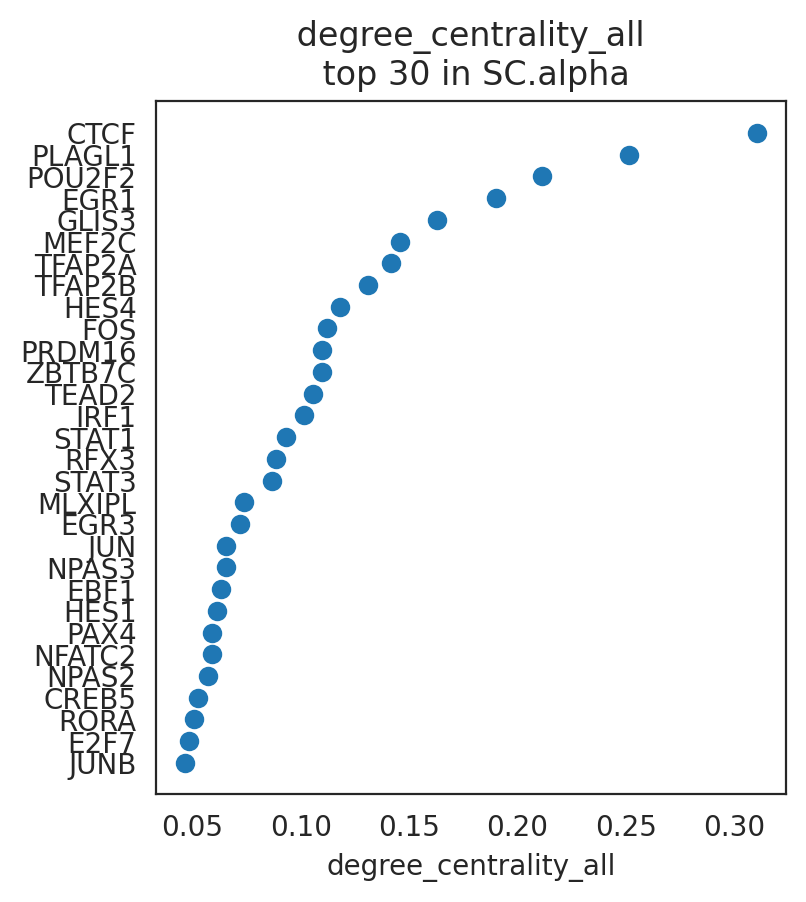

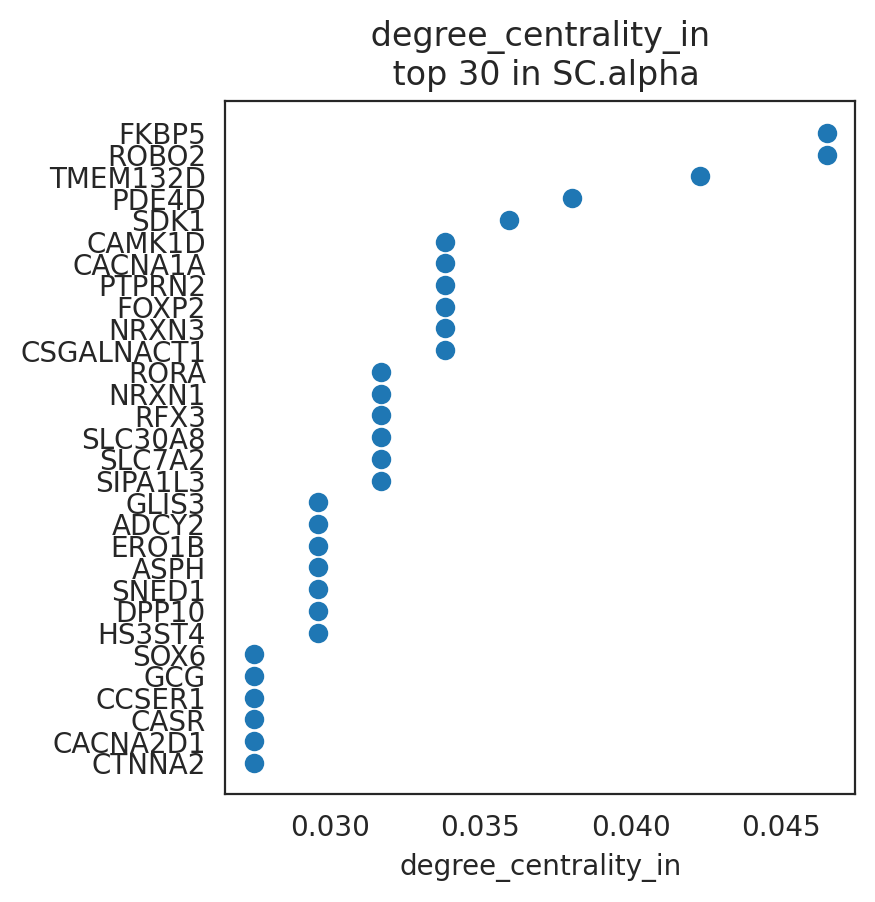

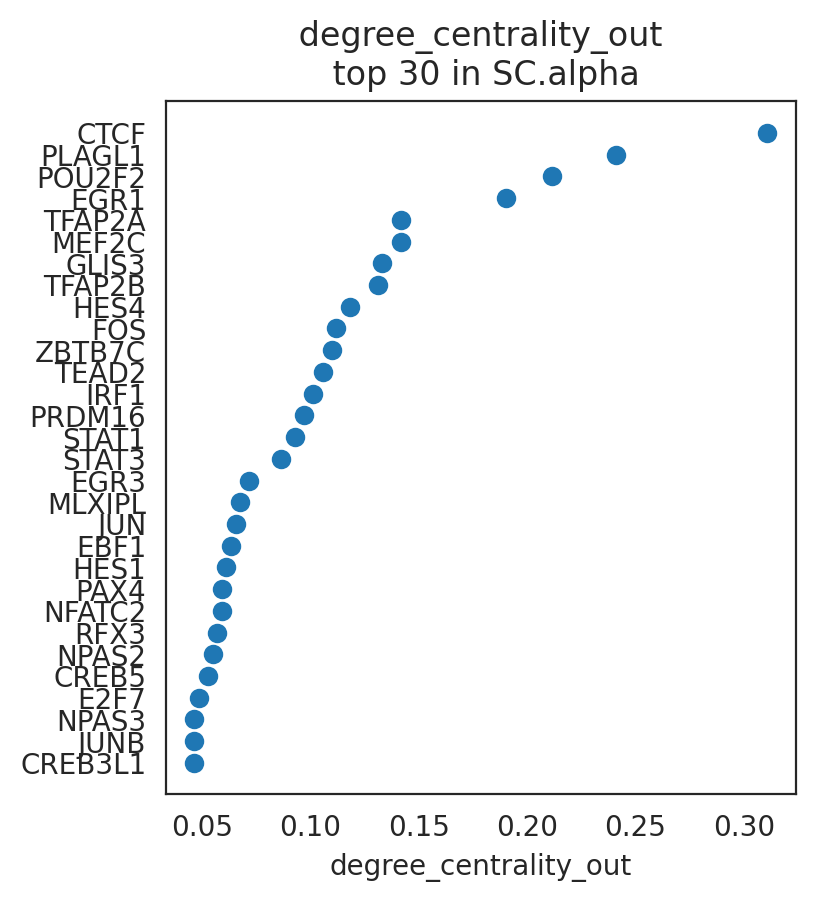

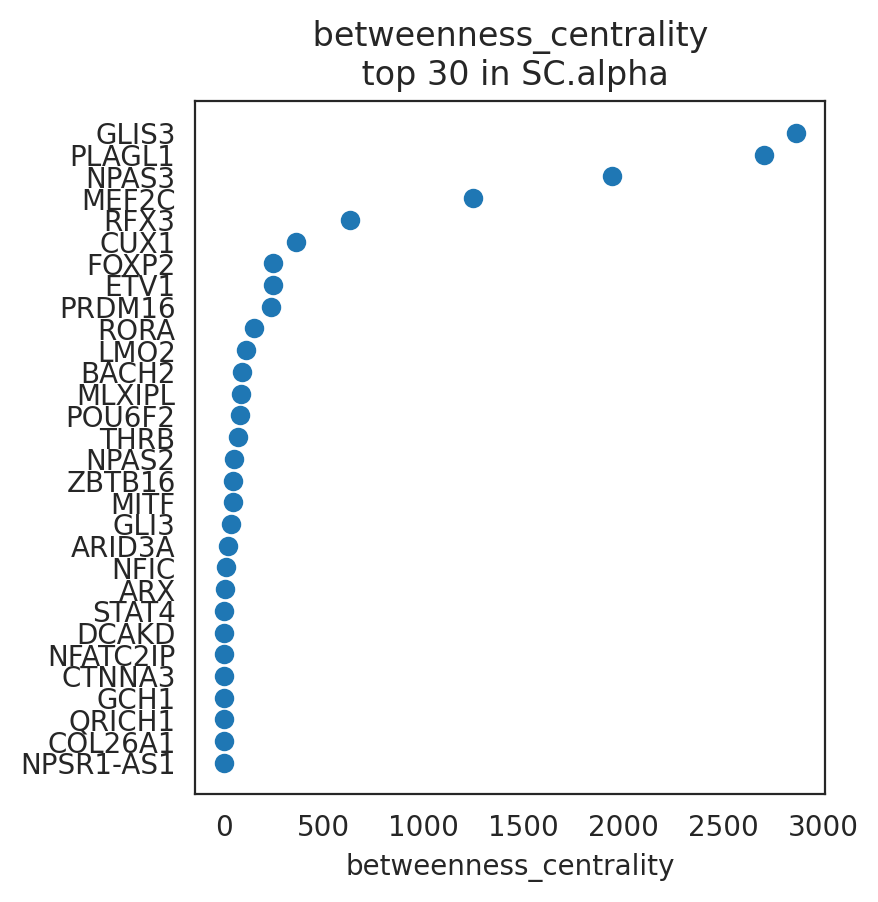

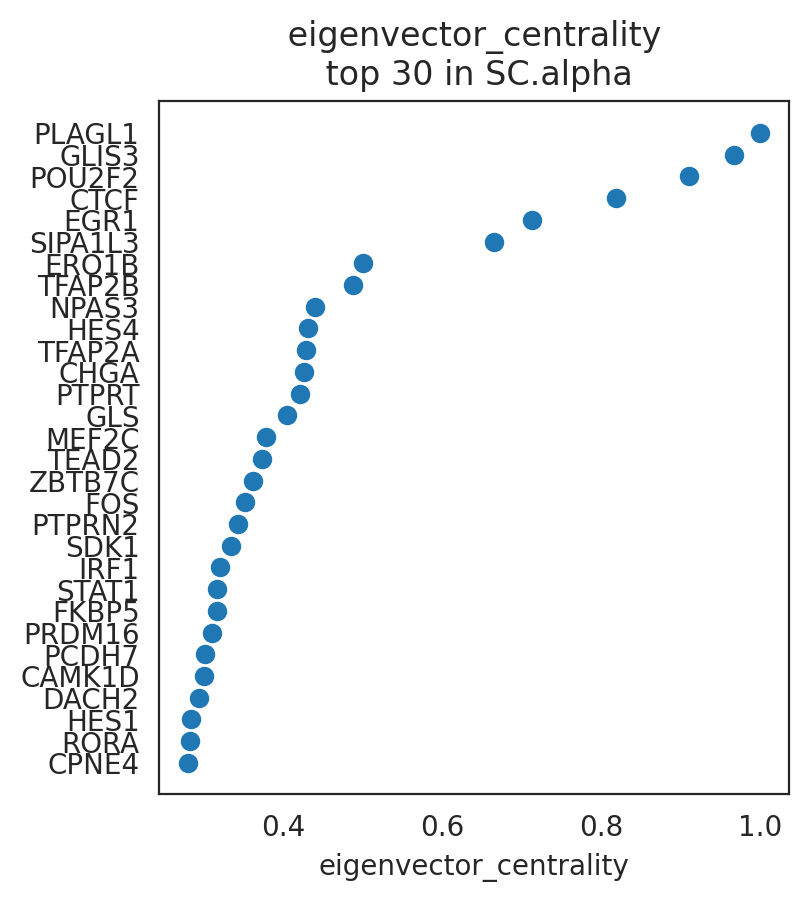

In [45]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="SC.alpha", n_gene=30)

IRF8


IndexError: single positional indexer is out-of-bounds

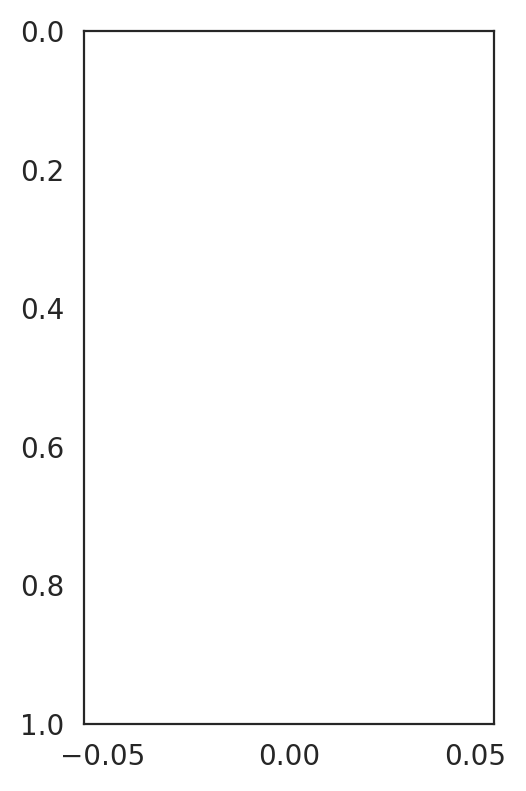

In [54]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="IRF8")

GCG


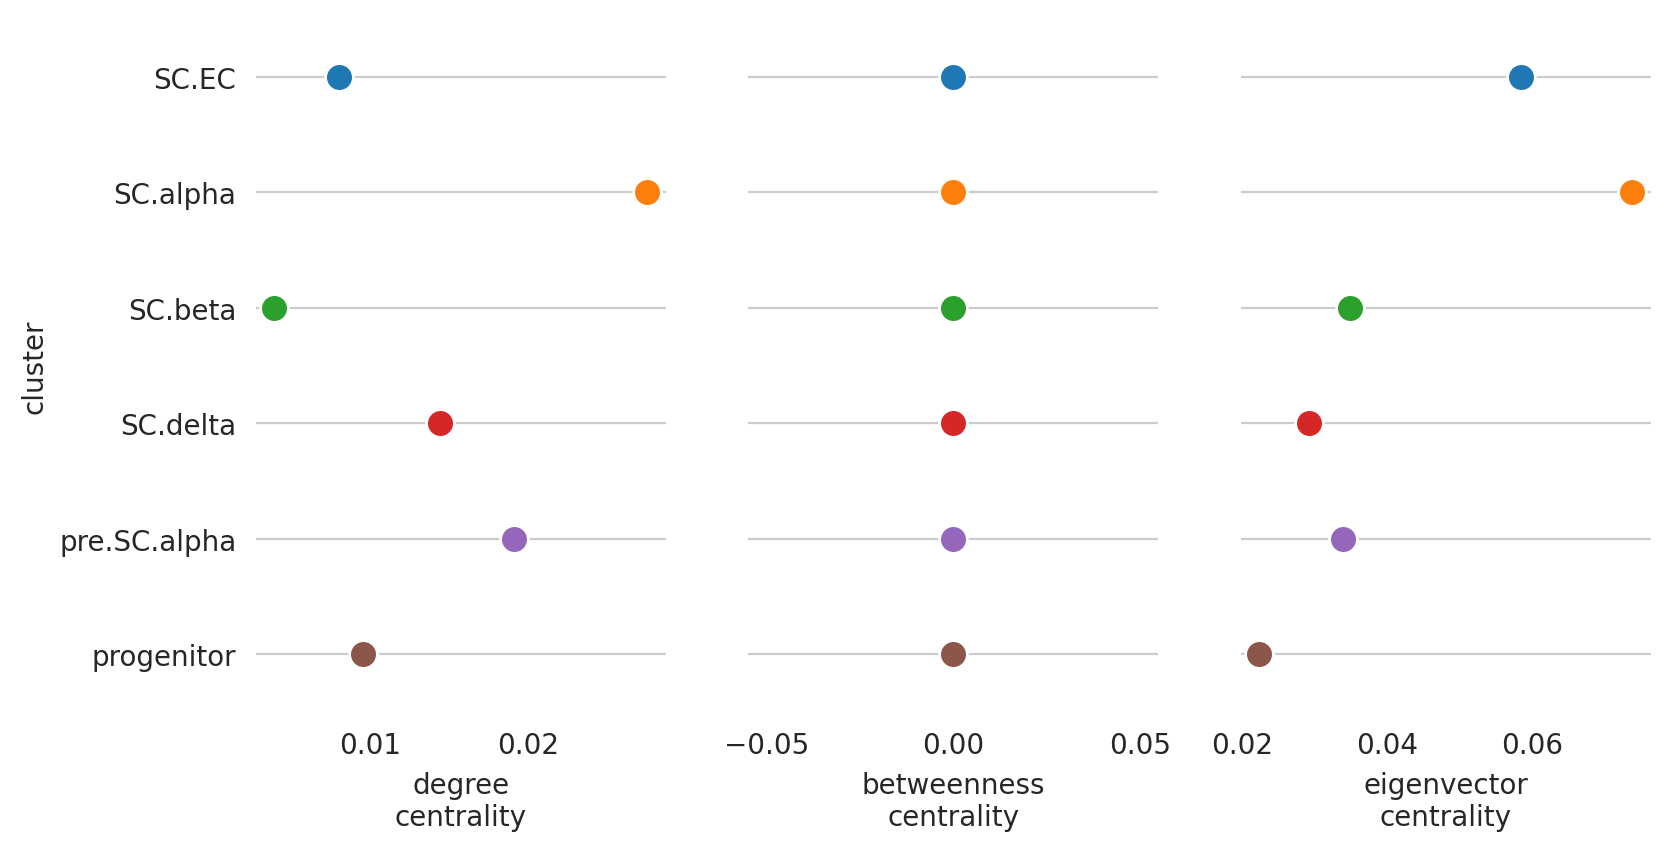

In [44]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="GCG")

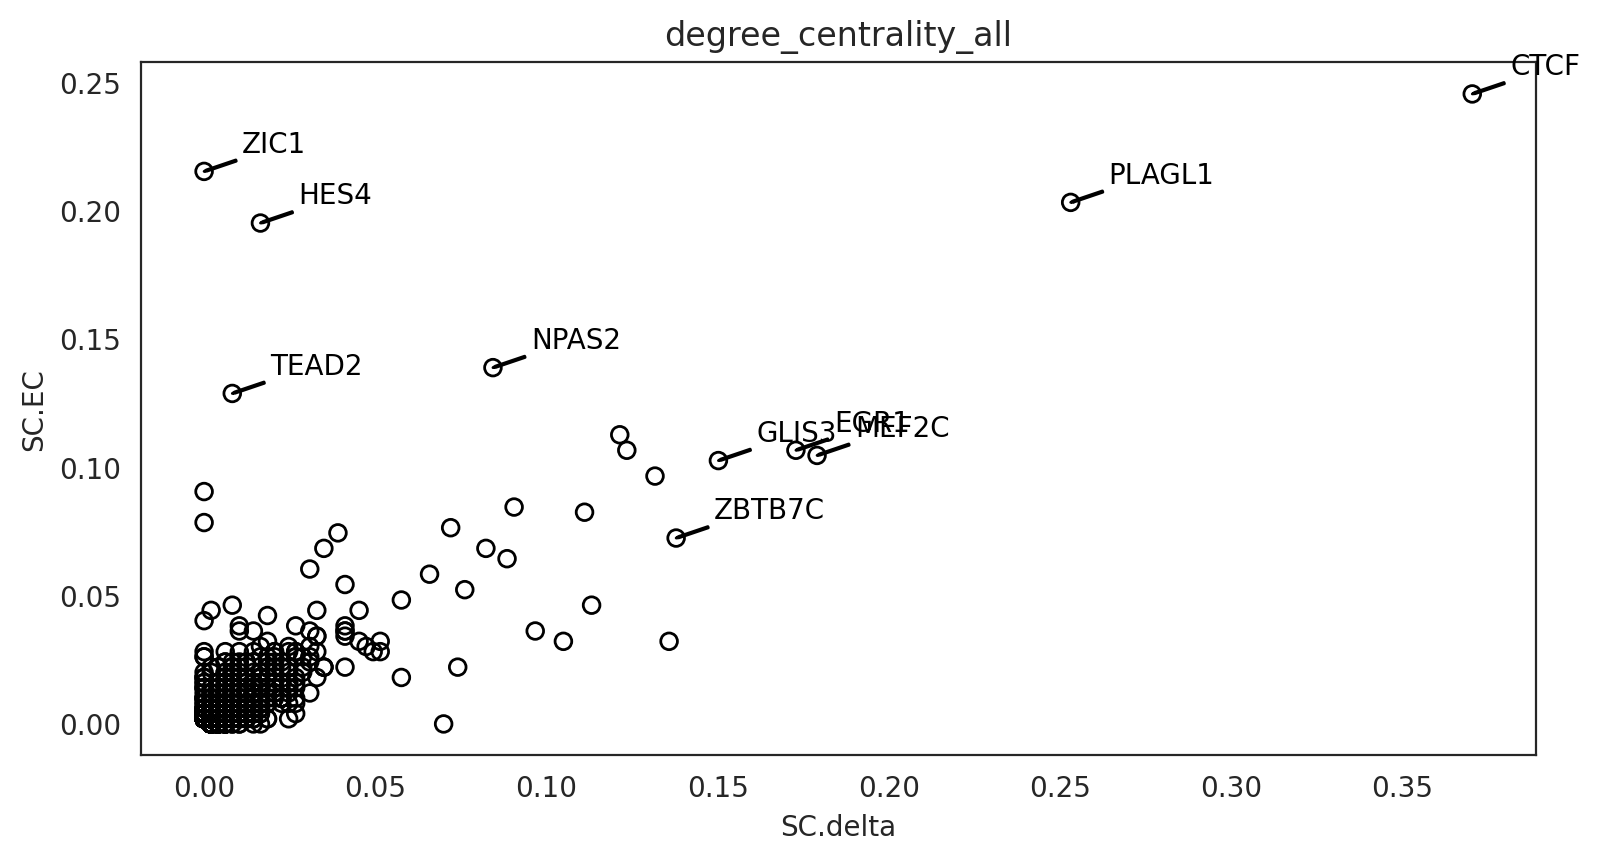

In [55]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(
    value="degree_centrality_all",
    cluster1="SC.delta", 
    cluster2="SC.EC"
)